In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
from numcosmo_py.helper import npa_to_seq
import timeit
import time


from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery

Ncm.cfg_init()
%matplotlib inline

In [2]:
pz_min = 0.1
pz_max = 1.1
logRmin = 0
logRmax = np.log(200) 

# We are loading the cosmoDC2_redmapper catalalog with richness
redmapper_cat = GCRCatalogs.load_catalog("cosmoDC2_v1.1.4_redmapper_v0.8.1")

# Taking some important information about the fiducial cosmological model and survey region
redmapper_cosmology = redmapper_cat.cosmology
sky_area = redmapper_cat.sky_area
# Listing all quantities in the choosen catalog
#np.sort(redmapper_cat.list_all_quantities())
#print(np.sort(redmapper_cat.list_all_quantities()))

data_redmapper = redmapper_cat.get_quantities(
    ["cluster_id", "redshift", "redshift_err", "richness", "richness_err", "ra", "dec"],
    filters=[
        f"redshift > {pz_min}",
        f"redshift < {pz_max}",
        f"richness > {10**logRmin}",
        f"richness < {10**np.log10(200)}",
    ],
)
data_redmapper = Table(data_redmapper)
data_redmapper['richness'] = np.log(data_redmapper['richness'])

#image_cat['halo_mass'].size()
table_redmapper_halos = fits.open("catalogs/redmapper_halos.fits")[1].data
table_redmapper_halos['R'] = np.log(table_redmapper_halos['R'])
data_redmapper_matched = Table(table_redmapper_halos)

data_redmapper_matched = table_redmapper_halos[(table_redmapper_halos['R'] <= logRmax) & (table_redmapper_halos['z'] <= 1.1) & (table_redmapper_halos['z'] >= 0.1)]
display(Table(table_redmapper_halos))
print("ra interval")
print(data_redmapper_matched['ra'].min())
print(data_redmapper_matched['ra'].max())
print('\n')

print("dec interval")
print(data_redmapper_matched['dec'].min())
print(data_redmapper_matched['dec'].max())
print('\n')

print("z interval")
print(data_redmapper_matched['z'].min())
print(data_redmapper_matched['z'].max())
print('\n')

print("richness interval")
print(data_redmapper_matched['R'].min())
print(data_redmapper_matched['R'].max())
print('\n')

print("sky_area = %.3f sqd" % (sky_area))
print(sky_area * (np.pi / 180) ** 2)




cut = data_redmapper_matched['R'].min()
lnR_max = np.log(200)

undetected = np.isin(data_redmapper['cluster_id'], data_redmapper_matched['cluster_id'],invert=True)
data_redmapper_unmatched = data_redmapper[undetected]

data_redmapper_unmatched

ID,RA,DEC,z,ID_matched,RA_matched,DEC_matched,z_matched,mass,halo_id,R,z_err,R_err,cluster_id
int64,float64,float64,float64,int64,float64,float64,float32,float64,int64,float32,float32,float32,int32
4844,69.25422243937102,-37.07944619620325,0.09059464931488037,29120,69.26261193094636,-37.12523267136146,0.09187007,12.094857151678758,66200130453,2.6760054,0.008295042,1.639027,13248
4885,68.27614070012815,-37.189991812496785,0.0908975601196289,25631,68.27525411959054,-37.19006406830496,0.09730887,13.481228871221369,20100129453,2.0961897,0.008068236,1.0486002,11608
5016,70.08361461794335,-26.036044416196162,0.09200990200042725,3944,70.07613565022369,-26.038307330502988,0.09453924,13.520894497909019,20900027453,1.9424379,0.008891889,1.085461,18373
5258,69.67742096349899,-25.621844155486755,0.0937948226928711,2213,69.6517262863478,-25.60916611130229,0.09787446,14.125098180919602,48100027453,2.9913204,0.007760804,1.4860177,3372
5409,49.3193831557647,-37.87136824612078,0.09498965740203857,31746,49.383518136268926,-37.860010264387654,0.100568734,12.451263388158331,15600137453,1.8290943,0.008822744,0.97603595,26410
5417,55.54948976681297,-27.533212985060075,0.09505760669708252,759,55.548063387183255,-27.55708451868613,0.10160569,14.005138129011694,4900031453,2.2061758,0.008325423,1.3314863,17559
5462,61.66404235682511,-33.6259257090185,0.09548544883728027,13317,61.65694067658684,-33.62162578736079,0.102951944,12.523658933642697,43700096453,1.6758723,0.008678786,1.0183109,46088
5618,51.335502032971064,-43.375583245727086,0.09672355651855469,31704,51.335876830398014,-43.37418651871164,0.098469906,13.807559976931657,16200175453,1.7286953,0.008132195,1.0438868,32845
5694,72.1600341846793,-28.801910086126227,0.09737443923950195,16649,72.15970720885345,-28.802335039057034,0.10203918,13.37147175437861,8300048453,1.739469,0.008648652,1.024512,34664


ra interval
47.82629157861663
75.90425795437356


dec interval
-46.51272396073861
-24.65221049346347


z interval
0.10035645961761475
1.0999622344970703


richness interval
1.6110057
5.266293


sky_area = 439.790 sqd
0.13396765544773198


ra,redshift_err,cluster_id,redshift,richness_err,richness,dec
float64,float32,int32,float32,float32,float32,float64
58.56362402841767,0.0060331975,30,0.63518524,3.6777163,5.120004,-27.429961828331713
56.01776126052891,0.005753637,605,0.7231654,2.642353,4.0445995,-24.863236899943406
59.35953891060911,0.00700932,610,0.6335041,2.6412973,4.041388,-26.88245156902106
55.72602030132123,0.0035100037,776,0.4932742,2.2188795,3.819937,-28.551621944143218
52.940786054153854,0.0035390393,911,0.47682086,2.3943121,3.834549,-26.077918984346976
55.5746045480562,0.0034995535,1003,0.49684155,2.0814,3.679369,-28.120838075085036
57.6541947998278,0.0062598395,1082,0.7220743,2.4489255,3.7684548,-26.422280779875944
57.136158168220874,0.0048869005,1176,0.58166313,2.7039995,3.7810545,-26.333385215523574
54.50040727038002,0.0060297484,1166,0.3245388,2.7281806,3.7900565,-27.729711177073696


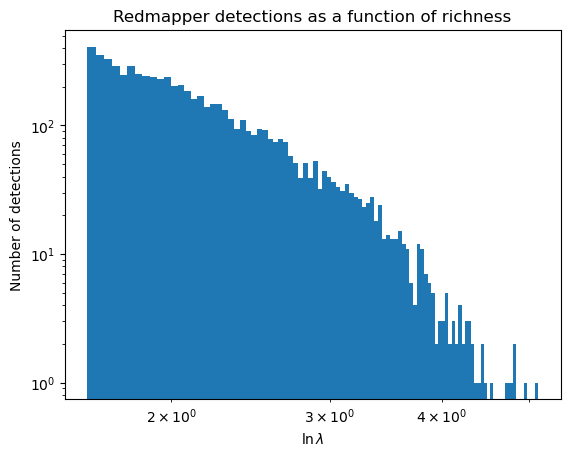

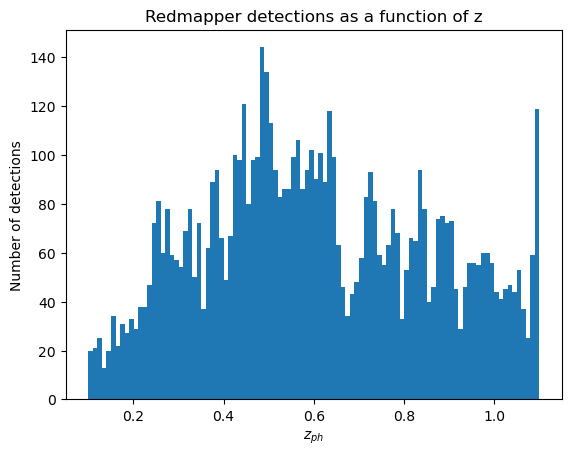

In [3]:
plt.hist(data_redmapper_unmatched['richness'],bins=100)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.show()

plt.hist(data_redmapper_unmatched['redshift'],bins=100)
plt.title("Redmapper detections as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.show()

# Completeness Model

In [4]:
lnM_bins_knots = np.linspace(13.0 * np.log(10), 16 * np.log(10) ,10)
lnM_bins_knots = np.linspace(11.9 * np.log(10), 15 * np.log(10) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnM_centers = 0.5 * (lnM_bins_knots[:-1] + lnM_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

completeness_knots = Ncm.Matrix.new(len(z_centers),len(lnM_centers))
'''
completeness_smooth_clipped = np.array([[0.00775574, 0.0257542, 0.03300902, 0.03199418, 0.02518367, 0.01505147, 0.00407155, 0.0, 0.0],
    [0.25260502, 0.27061681, 0.27605795, 0.2718841, 0.26105089, 0.24651397, 0.23122899, 0.21336439, 0.21044216],
    [0.40262404, 0.43122535, 0.4456371, 0.44914992, 0.44505445, 0.43664132, 0.42720117, 0.41831353, 0.42562491],
    [0.50266196, 0.54495916, 0.57169553, 0.58647906, 0.59291775, 0.59461957, 0.59519252, 0.60182781, 0.62621808],
    [0.59756795, 0.64919758, 0.68418232, 0.70655894, 0.72036417, 0.72963479, 0.73840753, 0.75946354, 0.80210609],
    [0.73219118, 0.78131995, 0.81304655, 0.83207695, 0.84311712, 0.85087303, 0.86005064, 0.88677706, 0.94317338],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0],
    [0.95138081, 0.9787056, 0.98823728, 0.98572051, 0.97689998, 0.96752036, 0.96332631, 0.97932468, 1.0]])

'''
completeness_smooth_clipped = np.array([[0.00119422126, 0.00281493621, 0.00300747736, 0.00228161573, 0.00218630487, 0.00190457050, 0.00128858137, 0.00135798388, 0.000823192247],
 [0.00257248346, 0.00428586091, 0.00685292638, 0.00443412452, 0.00484914622, 0.00418188519, 0.00246400910, 0.00255414149, 0.00135943029],
 [0.00618975878, 0.0100523280, 0.0141343696, 0.0121077444, 0.0118949221, 0.0111484982, 0.00703048140, 0.00646028836, 0.00480680526],
 [0.0369924839, 0.0418512744, 0.0472842241, 0.0496313367, 0.0479783727, 0.0331788502, 0.0223094701, 0.0170701668, 0.0105233141],
 [0.144478892, 0.148452493, 0.157501135, 0.172913874, 0.180015395, 0.135133711, 0.122016379, 0.100503054, 0.101546068],
 [0.346975669, 0.401193069, 0.405397060, 0.440418247, 0.442804044, 0.398720088, 0.427402052, 0.382703798, 0.444831860],
 [0.573356732, 0.585746894, 0.641882643, 0.669521128, 0.624506136, 0.606200115, 0.700544251, 0.597697307, 0.669063143],
 [0.610688067, 0.639754153, 0.629681103, 0.693391439, 0.674377330, 0.699885494, 0.797381682, 0.748818824, 0.740584334],
 [0.626335943, 0.792435821, 0.658813712, 0.943957277, 0.804286888, 0.709967027, 0.800181480, 0.833691572, 0.999913635]])


for i in range(len(z_centers)):
    for j in range(len(lnM_centers)):
        completeness_knots.set(i,j, completeness_smooth_clipped.T[i][j])

completeness = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnM_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=completeness_knots
)
completeness.prepare()
completeness.integ_dxdy(np.log(1e12), np.log(1e16), 0.1, 1.1)

7.4408125400885154

# Purity Model

In [5]:
lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))
z_bins_knots = np.array([0.1, 0.2 ,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])

purity_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))

purity_smooth_clipped = np.array([[1.443, 1.335, 1.244, 1.241, 1.182, 1.138, 1.145, 1.148, 1.088],
 [1.346, 1.361, 1.190, 1.222, 1.217, 1.171, 1.157, 1.137, 1.125],
 [1.410, 1.367, 1.180, 1.200, 1.251, 1.188, 1.116, 1.132, 1.081],
 [1.384, 1.325, 1.213, 1.183, 1.227, 1.202, 1.094, 1.126, 1.101],
 [1.246, 1.095, 1.188, 1.124, 1.149, 1.162, 1.119, 1.068, 1.114],
 [1.482, 1.088, 1.137, 1.043, 1.072, 1.069, 1.148, 1.068, 1.075],
 [1.504, 1.198, 1.005, 1.000, 1.104, 1.254, 1.175, 1.000, 1.000]])
'''
purity_smooth_clipped = np.array([[1, 1, 1, 1, 1, 1,
 1 , 1 , 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1],
 [1, 1 , 1 , 1, 1 ,1 , 1, 1, 1]])
 '''

for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        purity_knots.set(i,j, purity_smooth_clipped.T[i][j])

purity = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=purity_knots
)
purity.prepare()

purity.integ_dxdy(np.log(5), np.log(200), 0.1, 1.1)

4.314152047464849

# Cosmological Model

In [6]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
#cosmo.omega_x2omega_k()
#cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("Omegax", redmapper_cosmology.Ode0)
cosmo.param_set_by_name("H0", redmapper_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", redmapper_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", redmapper_cosmology.Odm0)  # 0.2603
cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA = redmapper_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (redmapper_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(redmapper_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.7764593327536546
0.8 0.8 3.0597349179015914


# Cluster Mass-Richness and photoz model 

In [7]:
cut = np.log(5)
cluster_m = Nc.ClusterMassSelection(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m.param_set_by_name("mup0", 4.12769558168741)
cluster_m.param_set_by_name("mup1", 1.17476066603899)
cluster_m.param_set_by_name("mup2", 0.393577193825473 )
cluster_m.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m.param_set_by_name("sigmap2", -0.0644996574273048 )
#cluster_m.set_ipurity(purity)
cluster_m.set_completeness(completeness)
cluster_m.set_lnM_limits(Ncm.Vector.new_array(npa_to_seq([np.log(10)* 12.0, np.log(10)* 16])))
cluster_m.param_set_by_name("cut", cut)


cut = np.log(5)
cluster_m_all = Nc.ClusterMassSelection(lnRichness_min = cut ,lnRichness_max = lnR_max) #z0=0.5,M0=10**(14.3)
cluster_m_all.param_set_by_name("mup0", 4.12769558168741)
cluster_m_all.param_set_by_name("mup1", 1.17476066603899)
cluster_m_all.param_set_by_name("mup2", 0.393577193825473 )
cluster_m_all.param_set_by_name("sigmap0", 0.408750324989284)
cluster_m_all.param_set_by_name("sigmap1", -0.123232985316648)
cluster_m_all.param_set_by_name("sigmap2", -0.0644996574273048 )
cluster_m_all.set_ipurity(purity)
cluster_m_all.set_completeness(completeness)
cluster_m_all.set_lnM_limits(Ncm.Vector.new_array(npa_to_seq([np.log(10)* 12.0, np.log(10)* 16])))
cluster_m_all.param_set_by_name("cut", cut)

In [8]:
cluster_z = Nc.ClusterPhotozGauss(pz_min = z_bins_knots[0],pz_max = z_bins_knots[-1])
z_bins_knots = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])
z_bin = [(z_bins_knots[i] +z_bins_knots[i+1])/2 for i in range(len(z_bins_knots)-1)]

sigma_SN        = np.array([])
sigma_intrinsic = np.array([])
for i in range(len(z_bins_knots)-1):
    data_bin = data_redmapper_matched[(data_redmapper_matched['z'] >= z_bins_knots[i]) & (data_redmapper_matched['z']< z_bins_knots[i+1])]
    sigma_SN = np.append(sigma_SN, np.sum([(data_bin['z'][j] - z_bin[i])**2 for j in range(len(data_bin['z']))]))
    sigma_intrinsic = np.append(sigma_intrinsic, 1/(np.sum([1/data_bin['z_err'][j]**2 for j in range(len(data_bin['z_err'])) ])) )
    
sigma2_SN = sigma_SN/len(data_bin['z'])**2
sigma2_intrinsic = sigma_intrinsic**2
sigma = np.sqrt(sigma2_SN + sigma2_intrinsic)

photoz_err = Ncm.Matrix.new(len(sigma), 2)
photoz_err.set_zero()
photoz_err.set_col(1, Ncm.Vector.new_array(npa_to_seq(sigma)))

photoz_err.log_vals("photoz_err:" , "%.10f")

cluster_z = Nc.ClusterRedshiftNodist(z_min = z_bins_knots[0],z_max = z_bins_knots[-1])

photoz_err: 0.0000000000 0.0002068575
photoz_err: 0.0000000000 0.0003045960
0.00043580590.0000000000 
photoz_err: 0.0000000000 0.0005060143
photoz_err: 0.0000000000 0.0005666504
photoz_err: 0.0000000000 0.0005606456
photoz_err: 0.0000000000 0.0005399816
photoz_err: 0.0000000000 0.0014525613
photoz_err: 0.0000000000 0.0004582997


# Cluster abundance model

35960.515182351846
36347


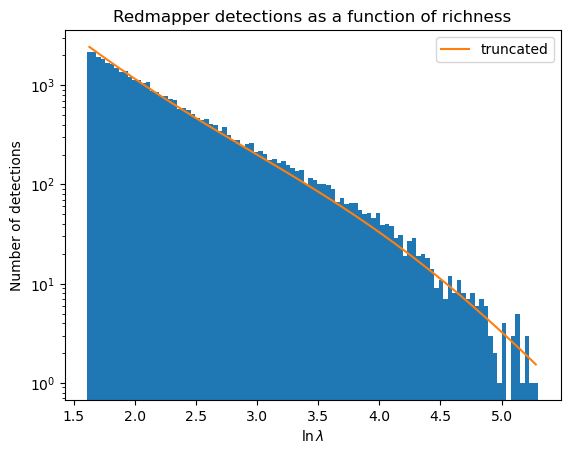

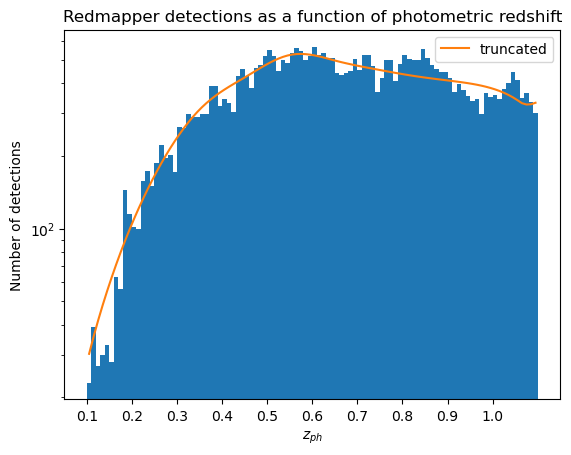

In [9]:
mulf = Nc.MultiplicityFuncDespali.new()
mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL)
#mulf.set_Delta(200.0)

hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
hmf.prepare(cosmo)
hmf.set_area(sky_area * (np.pi / 180) ** 2)
hbias = Nc.HaloBiasTinker.new(hmf)
cad = Nc.ClusterAbundance.new(hmf,hbias)
cad.set_area(sky_area * (np.pi / 180) ** 2)

cad_all = Nc.ClusterAbundance.new(hmf,hbias)
cad_all.set_area(sky_area * (np.pi / 180) ** 2)



cad.prepare(cosmo , cluster_z , cluster_m)
cad_all.prepare(cosmo , cluster_z , cluster_m_all)

nbins=100
lnM_obs = np.linspace(cut, np.log(200) , nbins +1) 
lnM_obs_bin = [(lnM_obs[i] +lnM_obs[i+1])/2 for i in range(len(lnM_obs)-1)]
z_obs = np.linspace(z_bins_knots[0], z_bins_knots[-1] , nbins +1)
z_obs_bin = [(z_obs[i] +z_obs[i+1])/2 for i in range(len(z_obs)-1)]


print(cad.n(cosmo ,cluster_z , cluster_m))
#print(cad.intp_bin_d2n(cosmo, cluster_z, cluster_m_ascaso, [cut] , [lnR_max], None, [pz_min] , [pz_max] , [0.00,0.03 * (1 + z_obs_bin[i])]))
red_mapper_20 = data_redmapper_matched[(data_redmapper_matched['R']>= cut) & (data_redmapper_matched['R'] < lnR_max) & (data_redmapper_matched['z'] >= pz_min) & (data_redmapper_matched['z'] < pz_max)]
print(len(red_mapper_20['R']))





abundance_lnM = np.array([])
abundance_lnM_all = np.array([])
for i in range(len(lnM_obs)-1):
    abundance_lnM = np.append(abundance_lnM,cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03]))
    abundance_lnM_all = np.append(abundance_lnM_all, cad.intp_bin_d2n(cosmo, cluster_z, cluster_m_all, [lnM_obs[i]] , [lnM_obs[i+1]], None, [pz_min] , [pz_max] , [0.00,0.03]))

abundance_z = np.array([])
abundance_z_all = np.array([])
for i in range(len(z_obs)-1):
    abundance_z = np.append(abundance_z, cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [cut] , [lnR_max], None, [z_obs[i]] , [z_obs[i+1]] , [0.00,0.03 * (1 + z_obs_bin[i])]))
    abundance_z_all = np.append(abundance_z_all,cad.intp_bin_d2n(cosmo, cluster_z, cluster_m_all, [cut] , [lnR_max], None, [z_obs[i]] , [z_obs[i+1]] , [0.00,0.03 * (1 + z_obs_bin[i])]))
    
plt.hist(red_mapper_20['R'],bins=lnM_obs)
plt.plot(lnM_obs_bin,abundance_lnM,label="truncated")
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper detections as a function of richness")
plt.legend()
plt.savefig("true_detecitons_R.png")
plt.show()

plt.hist(red_mapper_20['z'],bins=z_obs)
plt.plot(z_obs_bin,abundance_z,label="truncated")
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.xticks(np.arange(0.1, 1.1, step=0.1))
plt.title("Redmapper detections as a function of photometric redshift")
plt.legend()
plt.savefig("true_detecitons_z.png")
plt.show()

In [10]:
print((len(red_mapper_20['R']) - cad.n(cosmo ,cluster_z , cluster_m))/np.sqrt(len(red_mapper_20['R'])))
print((len(red_mapper_20['R']) - cad.n(cosmo ,cluster_z , cluster_m))/np.sqrt(cad.n(cosmo ,cluster_z , cluster_m)))

2.027207258875053
2.038071827130493


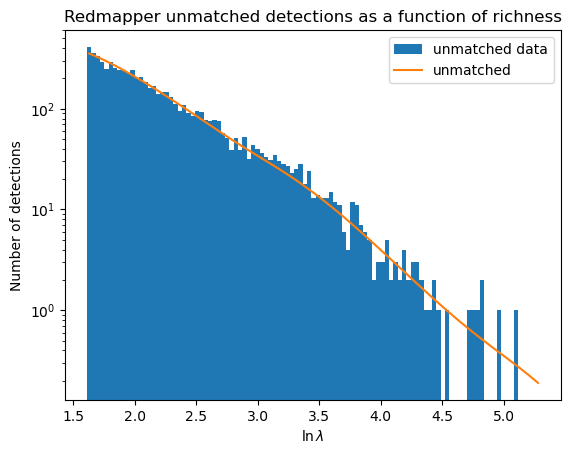

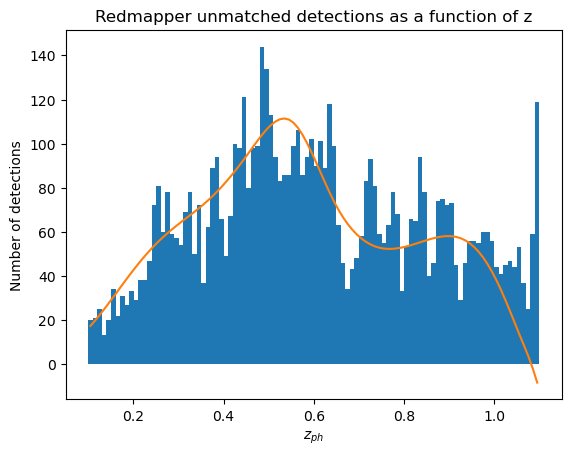

In [11]:
abundance_lnM_unmatched = [(abundance_lnM_all[i] - abundance_lnM[i])for i in range(len(abundance_lnM_all))]
abundance_z_unmatched = [abundance_z_all[i] - abundance_z[i] for i in range(len(abundance_z_all))]
plt.hist(data_redmapper_unmatched['richness'],bins=nbins,density=False, label='unmatched data')
plt.plot(lnM_obs_bin,abundance_lnM_unmatched,label="unmatched")
#plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln \lambda$")
plt.title("Redmapper unmatched detections as a function of richness")
plt.legend()
plt.show()

plt.hist(data_redmapper_unmatched['redshift'],bins=nbins,density=False , label='unmatched data')
plt.plot(z_obs_bin,abundance_z_unmatched,label="unmatched")
plt.title("Redmapper unmatched detections as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z_{ph}$")
plt.show()

In [12]:
print(len((unmatched[0] - detections[0])/detections[0]))
bins = [(detections[1][i] + detections[1][i+1])/2 for i in range(len(detections[1])-1)]
q = [1 - purity.integ_dy(bins[i] , 0.1, 1.1) for i in range(len(bins))]
plt.plot(bins,q, c= 'red')
plt.scatter(bins,(unmatched[0]/detections[0]))


NameError: name 'unmatched' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline
from scipy.integrate import quad 

lnR_bins_knots = np.log(np.array([5, 10, 15, 20, 35, 70, 100, 200]))
lnR_bins_knots = np.linspace(np.log(5), np.log(200) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR = data_redmapper['richness']
z   = data_redmapper['redshift']

# ---- INPUT ARRAYS ----
# lnR, z: shape (N,)
# detected: boolean, shape (N,)
# lnR_bins_knots, z_bins_knots: 1D arrays (edges)

# ---- BINNING ----
nR = len(lnR_bins_knots) - 1
nz = len(z_bins_knots) - 1

# 2D histogram for total and detected counts
H_total, _, _ = np.histogram2d(lnR, z, bins=[lnR_bins_knots, z_bins_knots])

# Compute completeness (observed / total)

# ---- BIN CENTERS ----
lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])
R, Z = np.meshgrid(lnR_centers, z_centers, indexing='ij')

# ---- SPLINE FITTING ----
# Fit only on bins with valid data
x_fit = R.ravel()
y_fit = Z.ravel()
z_fit = H_total.ravel()

# Choose internal knots (exclude boundaries)
tx = lnR_centers[1:-1]
ty = z_centers[1:-1]

#spline = LSQBivariateSpline(x_fit, y_fit, z_fit, tx, ty,eps=0.99)
spline = SmoothBivariateSpline(x_fit, y_fit, z_fit)
# Evaluate on full grid
Z_smooth = spline(lnR_centers, z_centers)
Z_smooth_clipped = np.clip(Z_smooth, 0.0, 1000000)

#print(H_total)
#print(Z_smooth_clipped)
#print(Z_smooth_clipped.T)
# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnR_bins_knots, z_bins_knots, H_total.T, cmap='viridis', shading='auto')
axes[0].set_title('Raw completeness')
fig.colorbar(pc0, ax=axes[0], label='Completeness')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnR_bins_knots, z_bins_knots, Z_smooth_clipped.T, cmap='viridis', shading='auto')
axes[1].set_title('Smoothed completeness')
fig.colorbar(pc1, ax=axes[1], label='Completeness')

# 3. Difference
diff = np.ma.masked_invalid(Z_smooth_clipped - H_total)
pc2 = axes[2].pcolormesh(lnR_bins_knots, z_bins_knots, diff.T, cmap='coolwarm', shading='auto')
axes[2].set_title('Smoothed - Raw')
fig.colorbar(pc2, ax=axes[2], label='Residual')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()


detection_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        detection_knots.set(i,j, Z_smooth_clipped.T[i][j])

detections_spline = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=detection_knots
)
detections_spline.prepare()

In [ ]:
lnR_interval = np.linspace(np.log(5) , np.log(200), 100) 
z_interval = np.linspace(0.1,1.1, 100) 
lnR_bins = [(lnR_interval[i] + lnR_interval[i+1])/2 for i in range(len(lnR_interval)-1)]
z_bins = [(z_interval[i] + z_interval[i+1])/2 for i in range(len(z_interval)-1)]

detections_all = [detections_spline.integ_dy(lnR_bins[i], 0.1,1.1)/detections_spline.integ_dxdy(lnR_interval[0],lnR_interval[-1], 0.1,1.1) for i in range(len(lnR_bins))]
detections_all_z = [detections_spline.integ_dx(lnR_interval[0],lnR_interval[-1],z_bins[i])/detections_spline.integ_dxdy(lnR_interval[0],lnR_interval[-1], 0.1,1.1) for i in range(len(z_bins))]


# Create a figure with two subplots (2 rows, 1 column)
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)  # Top plot is 3x taller than bottom
ax1 = fig.add_subplot(gs[0])  # Main plot (top)
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Residual plot (bottom)

# --- Top Plot: Data vs Model ---
ax1.plot(lnR_bins, detections_all, label='Model Prediction', color='blue')
hist = ax1.hist(data_redmapper['richness'], bins=lnR_interval, density=True, 
                alpha=0.6, label='Observed Data', color='orange')
ax1.set_yscale("log")
ax1.legend()
ax1.set_ylabel('Density (log scale)')

# --- Bottom Plot: Residuals ---
residuals = (detections_all - hist[0]) / hist[0]
ax2.plot(lnR_bins, residuals, 'o-', color='red', markersize=4, label='Residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero reference line
ax2.set_ylim(-0.5, 1)  # Adjusted to better show residuals
ax2.set_xlabel('ln(Richness)')
ax2.set_ylabel('(Model - Data)/Data')
ax2.legend(loc='upper right')

# Remove x-axis label from top plot (since bottom plot has it)
ax1.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()


# Create a figure with two subplots (2 rows, 1 column)
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.05)  # Top plot is 3x taller than bottom
ax1 = fig.add_subplot(gs[0])  # Main plot (top)
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Residual plot (bottom)

# --- Top Plot: Data vs Model ---
ax1.plot(z_bins, detections_all_z, label='Model Prediction', color='blue')
hist = ax1.hist(data_redmapper['redshift'], bins=z_interval, density=True, 
                alpha=0.6, label='Observed Data', color='orange')
ax1.set_yscale("log")
ax1.legend()
ax1.set_ylabel('Density (log scale)')

# --- Bottom Plot: Residuals ---
residuals = (detections_all_z - hist[0]) / hist[0]
ax2.plot(z_bins, residuals, 'o-', color='red', markersize=4, label='Residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero reference line
ax2.set_ylim(-0.5, 1)  # Adjusted to better show residuals
ax2.set_xlabel('z')
ax2.set_ylabel('(Model - Data)/Data')
ax2.legend(loc='upper right')

# Remove x-axis label from top plot (since bottom plot has it)
ax1.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()

In [ ]:
lnR_interval = np.linspace(np.log(5) , np.log(200), 100) 
lnR_bins = [(lnR_interval[i] + lnR_interval[i+1])/2 for i in range(len(lnR_interval)-1)]
detections_all = [detections_spline.integ_dy(lnR_bins[i], 0.1,1.1)/
                  (detections_spline.integ_dxdy(lnR_interval[0],lnR_interval[-1], 0.1,1.1))
                   for i in range(len(lnR_bins))]


# Create a figure with two subplots (2 rows, 1 column)
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.01)  # Top plot is 3x taller than bottom
ax1 = fig.add_subplot(gs[0])  # Main plot (top)
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Residual plot (bottom)

# --- Top Plot: Data vs Model ---
ax1.plot(lnR_bins, detections_all, label='Model Prediction', color='blue')
hist = ax1.hist(data_redmapper_unmatched['R'], bins=lnR_interval, density=True, 
                alpha=0.6, label='False Detection', color='orange')
ax1.set_yscale("log")
ax1.legend()
ax1.set_ylabel('Density (log scale)')

# --- Bottom Plot: Residuals ---
residuals = (detections_all - hist[0]) / hist[0]
ax2.plot(lnR_bins, residuals, 'o-', color='red', markersize=4, label='Residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero reference line
ax2.set_ylim(-0.5, 1)  # Adjusted to better show residuals
ax2.set_xlabel('ln(Richness)')
ax2.set_ylabel('(Model - Data)/Data')
ax2.legend(loc='upper right')

# Remove x-axis label from top plot (since bottom plot has it)
ax1.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import SmoothBivariateSpline
from scipy.integrate import quad 

lnR_bins_knots = np.linspace(np.log(5), np.log(200) ,10)
z_bins_knots = np.array([0.1 , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0, 1.1])

lnR = data_redmapper_unmatched['R']
z   = data_redmapper_unmatched['z']

# ---- INPUT ARRAYS ----
# lnR, z: shape (N,)
# detected: boolean, shape (N,)
# lnR_bins_knots, z_bins_knots: 1D arrays (edges)

# ---- BINNING ----
nR = len(lnR_bins_knots) - 1
nz = len(z_bins_knots) - 1

# 2D histogram for total and detected counts
H_total, _, _ = np.histogram2d(lnR, z, bins=[lnR_bins_knots, z_bins_knots])

# Compute completeness (observed / total)

# ---- BIN CENTERS ----
lnR_centers = 0.5 * (lnR_bins_knots[:-1] + lnR_bins_knots[1:])
z_centers = 0.5 * (z_bins_knots[:-1] + z_bins_knots[1:])
R, Z = np.meshgrid(lnR_centers, z_centers, indexing='ij')

# ---- SPLINE FITTING ----
# Fit only on bins with valid data
x_fit = R.ravel()
y_fit = Z.ravel()
z_fit = H_total.ravel()

# Choose internal knots (exclude boundaries)
tx = lnR_centers[1:-1]
ty = z_centers[1:-1]

#spline = LSQBivariateSpline(x_fit, y_fit, z_fit, tx, ty,eps=0.99)
spline = SmoothBivariateSpline(x_fit, y_fit, z_fit)
# Evaluate on full grid
Z_smooth = spline(lnR_centers, z_centers)
Z_smooth_clipped = np.clip(Z_smooth, 0.0, 50000)

#print(H_total)
#print(Z_smooth_clipped)
#print(Z_smooth_clipped.T)
# ---- PLOTTING ----
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)

# 1. Raw purity
pc0 = axes[0].pcolormesh(lnR_bins_knots, z_bins_knots, H_total.T, cmap='viridis', shading='auto')
axes[0].set_title('Raw completeness')
fig.colorbar(pc0, ax=axes[0], label='Completeness')

# 2. Smoothed purity
pc1 = axes[1].pcolormesh(lnR_bins_knots, z_bins_knots, Z_smooth_clipped.T, cmap='viridis', shading='auto')
axes[1].set_title('Smoothed completeness')
fig.colorbar(pc1, ax=axes[1], label='Completeness')

# 3. Difference
diff = np.ma.masked_invalid(Z_smooth_clipped - H_total)
pc2 = axes[2].pcolormesh(lnR_bins_knots, z_bins_knots, diff.T, cmap='coolwarm', shading='auto')
axes[2].set_title('Smoothed - Raw')
fig.colorbar(pc2, ax=axes[2], label='Residual')

for ax in axes:
    ax.set_xlabel('lnR')
    ax.set_ylabel('z')

plt.tight_layout()
plt.show()


detection_knots = Ncm.Matrix.new(len(z_centers),len(lnR_centers))
for i in range(len(z_centers)):
    for j in range(len(lnR_centers)):
        detection_knots.set(i,j, Z_smooth_clipped.T[i][j])

false_spline = Ncm.Spline2dBicubic(
spline=Ncm.SplineCubicNotaknot.new(),
x_vector=Ncm.Vector.new_array(npa_to_seq(lnR_centers)),
y_vector=Ncm.Vector.new_array(npa_to_seq(z_centers)),
z_matrix=detection_knots
)
detections_spline.prepare()

In [ ]:
lnR_interval = np.linspace(np.log(5) , np.log(200), 100) 
lnR_bins = [(lnR_interval[i] + lnR_interval[i+1])/2 for i in range(len(lnR_interval)-1)]
detections_all = [false_spline.integ_dy(lnR_bins[i], 0.1,1.1)/
                  (false_spline.integ_dxdy(lnR_interval[0],lnR_interval[-1], 0.1,1.1))
                   for i in range(len(lnR_bins))]


# Create a figure with two subplots (2 rows, 1 column)
fig = plt.figure(figsize=(8, 6))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0.01)  # Top plot is 3x taller than bottom
ax1 = fig.add_subplot(gs[0])  # Main plot (top)
ax2 = fig.add_subplot(gs[1], sharex=ax1)  # Residual plot (bottom)

# --- Top Plot: Data vs Model ---
ax1.plot(lnR_bins, detections_all, label='Model Prediction', color='blue')
hist = ax1.hist(data_redmapper_unmatched['R'], bins=lnR_interval, density=True, 
                alpha=0.6, label='False Detection', color='orange')
ax1.set_yscale("log")
ax1.legend()
ax1.set_ylabel('Density (log scale)')

# --- Bottom Plot: Residuals ---
residuals = (detections_all - hist[0]) / hist[0]
ax2.plot(lnR_bins, residuals, 'o-', color='red', markersize=4, label='Residuals')
ax2.axhline(0, color='gray', linestyle='--', linewidth=0.8)  # Zero reference line
ax2.set_ylim(-0.5, 1)  # Adjusted to better show residuals
ax2.set_xlabel('ln(Richness)')
ax2.set_ylabel('(Model - Data)/Data')
ax2.legend(loc='upper right')

# Remove x-axis label from top plot (since bottom plot has it)
ax1.tick_params(labelbottom=False)

plt.tight_layout()
plt.show()